In [1]:
from IPython.display import display, Math, Latex
# This is imported for proper rendering of Latex in Notebook.

import numpy as np

# import for generating plots
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Regularization

We implement *Ridge Regression* from scratch and *Lasso Regression* using the sklearn library in this notebook.

Polynomial Regression is able to model non-linear relationship between features and labels. However higher order polynomial models are prone to overfitting. There are $2$ ways to tackle this problem of overfitting:
1. Train with more data.
2. Penalize the weight vector through regularization.

Since, we have already seen the demonstration with $1$, we will see $2$  in this notebook.

- Regularization leads to change in Linear Regression loss function, which in turn results in change of gradient calculation.
- We plan to use regularization with Polynomial Regression model and synthetically generated non-linear data set.

The change in regularization rate results in a new model. For different values of regularization weights, we obtain a new model. Thus, we have a problem of model selection at hand, where we need to choose the best model among the list of candidate models.

Finally, we will also look at ridge and lasso solution path as a function of regularization rate $\lambda$.

We will reuse the code for polynomial transformation and non-linear data generation from polynomial regression colab.

# Ridge Regression

## Polynomial Transformation + Non-Linear Data Generation

### Non-Linear Data Generation

Creating Data

In [5]:
def create_nonlin_training_set(func, sample_size, std):
    '''
    Creates a training set where the output label is obtained by
    first calculating func(x) and then adding a small random noise
    having a gaussian distribution with a standard deviation of `std`.
    '''
    X = np.linspace(0,1, sample_size)
    y = func(X) + np.random.normal(scale=std, size = X.shape)
    return X,y

# In this example the non-linear function we will be using is the sin(2*pi*x) function
def nonlin_sin(x):
    return np.sin(2*np.pi*x)

Visualizing Data

In [6]:
def visualize_training_data(X_train, y_train):
    points = np.linspace(0,1,100)
    output = nonlin_sin(points)

    plt.figure()
    plt.scatter(X_train, y_train, facecolor ="none", edgecolor='b', s =50, label='training_data')
    plt.plot(points, output, c='g' ,label='$\sin(2\pi x)$')
    plt.xlabel('$x_1$')
    plt.ylabel('y')
    plt.legend()
    plt.show()

def visualize_model_fit(X,y, linear_model, degree):
    '''
    Plots trained model along with the data generation function.
    '''
    points = np.linspace(0,1,100)
    output = nonlin_sin(points)

    # plt.figure()
    if degree > 0:
        plt.scatter(X,y, facecolor="none", edgecolor='b', s =50, label='training_data')
    
    plt.plot(points, output, c='g', label='$\sin(2\pi x)$')

    # 'linear_model = LinReg()' object from the class LinReg as defined above.
    y_hat = linear_model.predict(polynomial_transform(points, degree))

    plt.plot(points, y_hat, c='r', label='$h_w(X)$')
    plt.xlabel('$x_1$')
    plt.ylabel('y')
    plt.ylim(-1.5,1.5)
    plt.title("Degree={}".format(degree))
    plt.legend()

### Polynomial Transformation

In [7]:
import itertools,functools

def get_combinations(x, degree):
    '''
    Return successive r-length combinations of elements in the iterable allowing individual elements to have successive repeats.

    combinations_with_replacement('ABC', 2) --> AA AB AC BB BC CC"
    '''
    return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
    '''
    reduce(function, sequence[, initial]) -> value

    Apply a function of two arguments cumulatively to the items of a sequence, from left to right, so as to reduce the sequence to a single value.

    For example: 
    reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates ((((1+2)+3)+4)+5). 
    
    If initial is present, it is placed before the items of the sequence in the calculation, and serves as a default when the sequence is empty.

    reduce(lambda x,y: x*y, [1, 2, 3, 4, 5]) calculates ((((1*2)*3)*4)*5).
    '''
    return functools.reduce(lambda x, y: x*y, items)

In [8]:
import numpy as np
import itertools,functools

def polynomial_transform(x, degree, logging=False):
    '''
    Steps for generating polynomial transformations of degree M ---
        
        1. Generate combination of input features of lengths = {0,1,...,M}.
        
        2. Perform multiplication operation between features to obtain the required new features.
    
    logging: Bool - True to print all the combinations and their products.
    '''
    
    # If 'x' is 1-dim, it is first converted to a feature matrix.
    # [1,2,3,4] to [[1],[2],[3],[4]]
    if x.ndim == 1:
        x = x[:,None]
    
    # Transpose of feature matrix
    x_t = x.transpose()

    # Populates 1's as first feature for each example, the degree 0 feature.
    features  = [np.ones(len(x))]

    if logging:
        print("Input: ",x)
    
    # for each degree d
    for d in range(1, degree+1):
        # generate combinations of degree d
        for x in get_combinations(x_t, d):
            # take product of no.s in x, and combine them into a single feature
            features.append(compute_new_feature(x))
            if logging:
                print(x,compute_new_feature(x), sep = ': ')
    
    if logging:
        print("Output: ", np.asarray(features).transpose())
    
    return np.asarray(features).transpose()

## Modified LinReg Class

We will implement Ridge Regression by making the following changes to the Linear Regression implementation:
1. Loss Function (`loss`): $\frac{1}{2} (Xw - y)^T (Xw - y) + \frac{\lambda}{2} w^T w$
2. Gradient calculation (`calculate_gradient`): $\frac{\partial J(w)}{\partial w} = X^T (Xw - y) + \lambda w$
3. Normal equation (`fit`): $(X^T X + \lambda I)^{-1} X^T y$

In [49]:
class LinReg(object):
    '''
    Modified Linear Regression model
    -----------------------
    y = X@w
    X: Feature matrix
    w: Weight vector
    y: Label vector
    λ: Regularization Rate
    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 100000
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        '''Prediction of output label for a given input.

        Args:
            X: Feature matrix for given inputs
        
        Returns:
            y: Output label vector as predicted by the given model
        '''

        y = X @ self.w
        
        return y
    
    def loss(self, X:np.ndarray, y:np.ndarray, reg_rate:float=0) -> float:
        '''Calculate loss for a model based on actual labels.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (actual labels)
            reg_rate: Rate of regularization
        
        Returns:
            Loss
        '''

        e = y - self.predict(X)
        # return (1/2) * (np.transpose(e) @ e)
        return (1/2) * (np.transpose(e) @ e) + (reg_rate/2) * (np.transpose(self.w) @ self.w)
    
    def rmse(self, X:np.ndarray, y:np.ndarray, reg_rate:float=0) -> float:
        '''Calculate root mean squared error of prediction based on actual labels.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (actual label)
            reg_rate: Rate of regularization
        
        Returns:
            RMSE
        '''
        return np.sqrt((2/X.shape[0]) * self.loss(X,y,reg_rate))
    
    # Normal Equation based estimation
    def fit(self, X:np.ndarray, y:np.ndarray, reg_rate:float=0) -> np.ndarray:
        '''Estimate parameters of linear regression model with normal equation.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (actual label)
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector via normal equation
        '''
        # self.w = np.linalg.pinv(X) @ y

        self.w = np.zeros((X.shape[1],y.shape[1]))
        eye = np.eye(np.size(X,1))
        self.w = np.linalg.solve(
            reg_rate * eye + X.T @ X,
            X.T @ y,
        )

        return self.w
    
    def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate:float=0) -> np.ndarray:
        '''Calculate gradients of loss function w.r.t. weight vector on training set.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (actual label)
            reg_rate: Rate of regularization
        
        Returns:
            A vector of gradients
        '''
        return np.transpose(X) @ (self.predict(X) - y) + reg_rate * self.w
    
    def update_weights(self, grad:np.ndarray, lr:float) -> np.ndarray:
        '''Update the weights based on the gradient of the loss function.

        Weight updates are carried out with the following formula:
            w_new := w_old - lr * grad
        
        Args:
            grad: Gradient of loss w.r.t w
            lr: Learning rate
        
        Returns:
            Updated weight vector
        '''
        return self.w - lr * grad
    
    # Dynamic learning rate
    def learning_schedule(self, t):
        return self.t0/(t + self.t1)
    
    # GD - Gradient Descent
    def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float, reg_rate:float=0) -> np.ndarray:
        '''Estimates parameters of linar regression model through gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training data vector
            num_epochs: Number of training steps
            lr: Learning rate
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []
        
        for i in np.arange(0, num_epochs):
            dJdW = self.calculate_gradient(X,y,reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y,reg_rate))
            self.w = self.update_weights(dJdW, lr)
        
        return self.w
    
    # MBGD - Mini-Batch Gradient Descent
    def mbgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size:int, reg_rate:float=0) -> np.ndarray:
        '''Estimates parameters of linar regression model through mini-batch gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training data vector
            num_epochs: No. of epochs (no. of times MBGD is done over the whole training set)
            batch_size: Size of each mini-batch, after which we update the weights
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []
        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                
                # ith mini-batch
                Xi = X_shuffled[i:i + batch_size]
                yi = y_shuffled[i:i + batch_size]

                lr = self.learning_schedule(mini_batch_id)
                gradients = (2/ batch_size) * self.calculate_gradient(Xi, yi, reg_rate)

                self.w_all.append(self.w)
                self.err_all.append(self.loss(Xi, yi, reg_rate))
                self.w = self.update_weights(gradients, lr)
        
        return self.w
    
    # SGD - Stochastic Gradient Descent
    def sgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, reg_rate:float=0) -> np.ndarray:
        '''Estimates parameters of linar regression model through stochastic gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training data vector
            num_epochs: No. of epochs (no. of times MBGD is done over the whole training set)
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = np.random.randint(X.shape[0])
                Xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                lr = self.learning_schedule(epoch * X.shape[0] + i)
                gradients = 2 * self.calculate_gradient(Xi, yi, reg_rate)

                self.w_all.append(self.w)
                self.err_all.append(self.loss(Xi,yi,reg_rate))
                self.w = self.update_weights(gradients, lr)
        
        return self.w


## Ridge Regression for fixing overfitting in Polynomial Regression

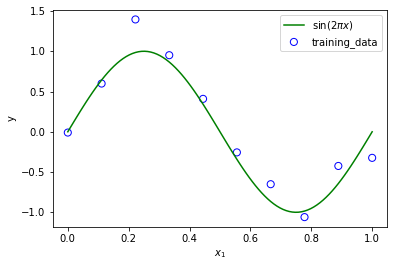

In [10]:
# Creating a sample of 10 examples.
num_samples = 10
X,y = create_nonlin_training_set(nonlin_sin, sample_size=num_samples, std=0.2)

visualize_training_data(X,y)

We fix the no. of samples to $10$ and check the overfitting occuring here.

We now check the fits for different values of regularization rate $\lambda$.

We vary the values of $\lambda \in \{0, 0.001, 0.01, 0.1, 1, 10\}$.

For each values of $\lambda$ we check the value of weights in higher degrees, where overfitting occurs. We check of degree $m \in \{3,5,7,9\}$

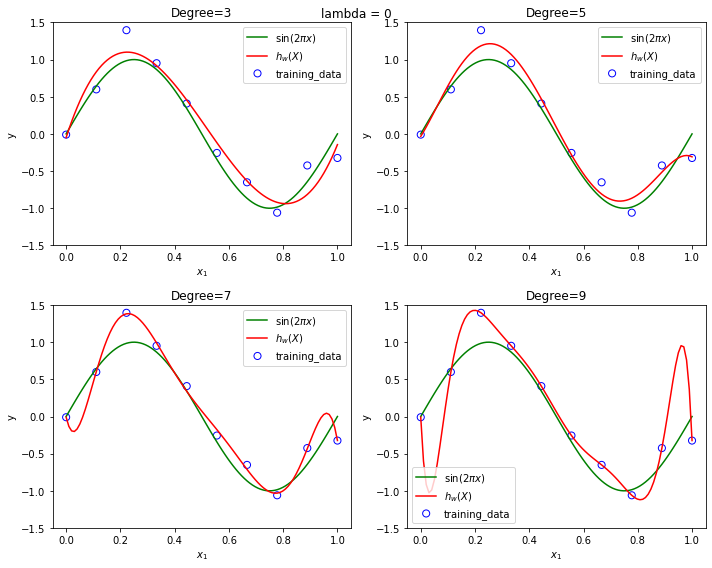

In [11]:
reg_rate = 0

fig = plt.figure(figsize=(10,8))

for i, degree in enumerate([3,5,7,9]):
    plt.subplot(2,2, i+1)

    X_transform = polynomial_transform(X, degree=degree)

    lin_reg = LinReg()
    lin_reg.fit(X_transform,y, reg_rate)

    visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

fig.tight_layout()
fig.suptitle('lambda = ' + str(reg_rate))
plt.show()

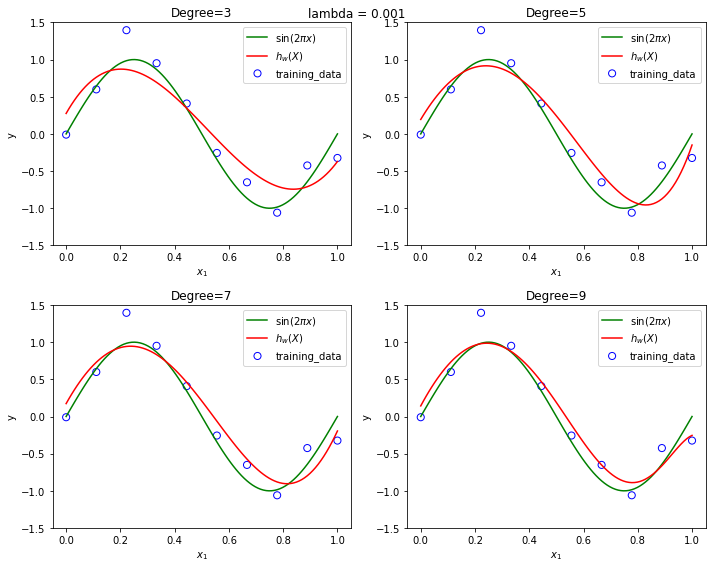

In [12]:
reg_rate = 0.001

fig = plt.figure(figsize=(10,8))

for i, degree in enumerate([3,5,7,9]):
    plt.subplot(2,2, i+1)

    X_transform = polynomial_transform(X, degree=degree)

    lin_reg = LinReg()
    lin_reg.fit(X_transform,y, reg_rate)

    visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

fig.tight_layout()
fig.suptitle('lambda = ' + str(reg_rate))
plt.show()

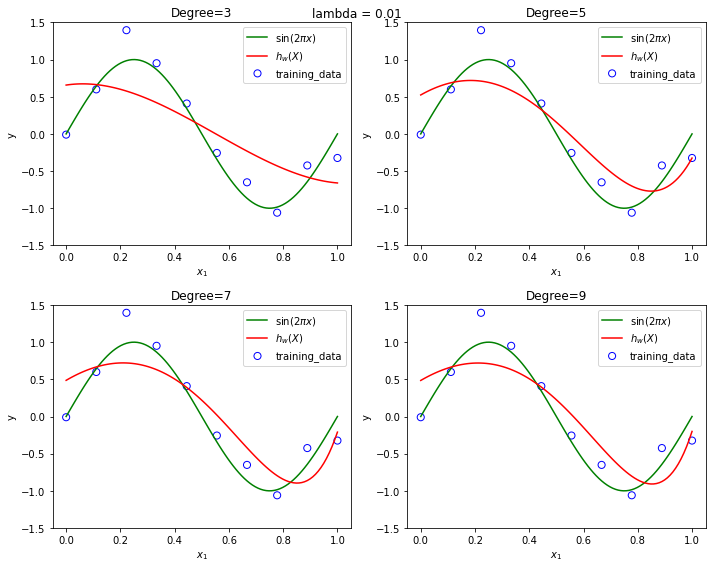

In [13]:
reg_rate = 0.01

fig = plt.figure(figsize=(10,8))

for i, degree in enumerate([3,5,7,9]):
    plt.subplot(2,2, i+1)

    X_transform = polynomial_transform(X, degree=degree)

    lin_reg = LinReg()
    lin_reg.fit(X_transform,y, reg_rate)

    visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

fig.tight_layout()
fig.suptitle('lambda = ' + str(reg_rate))
plt.show()

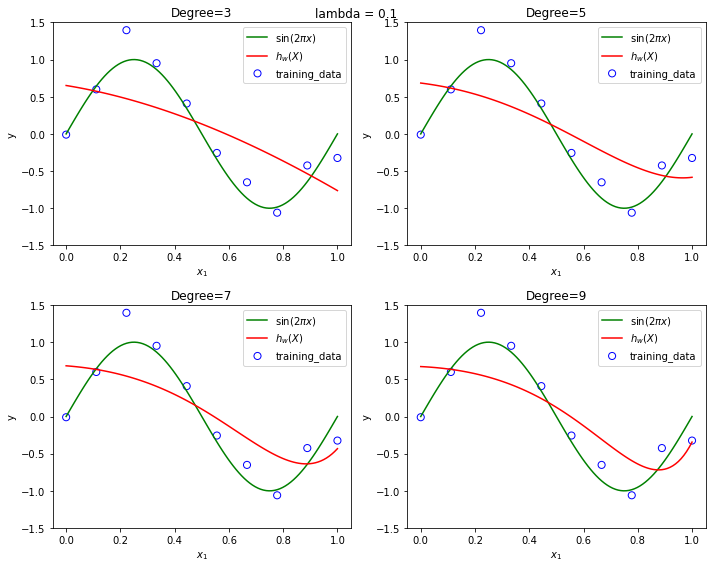

In [14]:
reg_rate = 0.1

fig = plt.figure(figsize=(10,8))

for i, degree in enumerate([3,5,7,9]):
    plt.subplot(2,2, i+1)

    X_transform = polynomial_transform(X, degree=degree)

    lin_reg = LinReg()
    lin_reg.fit(X_transform,y, reg_rate)

    visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

fig.tight_layout()
fig.suptitle('lambda = ' + str(reg_rate))
plt.show()

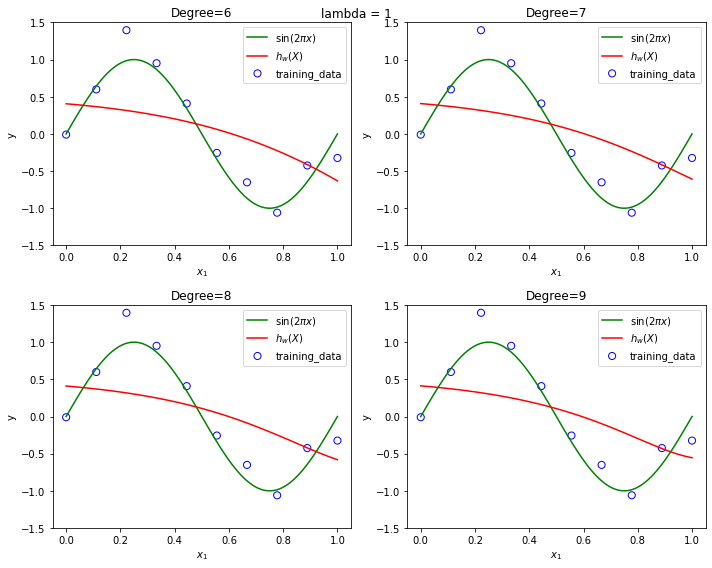

In [15]:
reg_rate = 1

fig = plt.figure(figsize=(10,8))

for i, degree in enumerate([6,7,8,9]):
    plt.subplot(2,2, i+1)

    X_transform = polynomial_transform(X, degree=degree)

    lin_reg = LinReg()
    lin_reg.fit(X_transform,y, reg_rate)

    visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

fig.tight_layout()
fig.suptitle('lambda = ' + str(reg_rate))
plt.show()

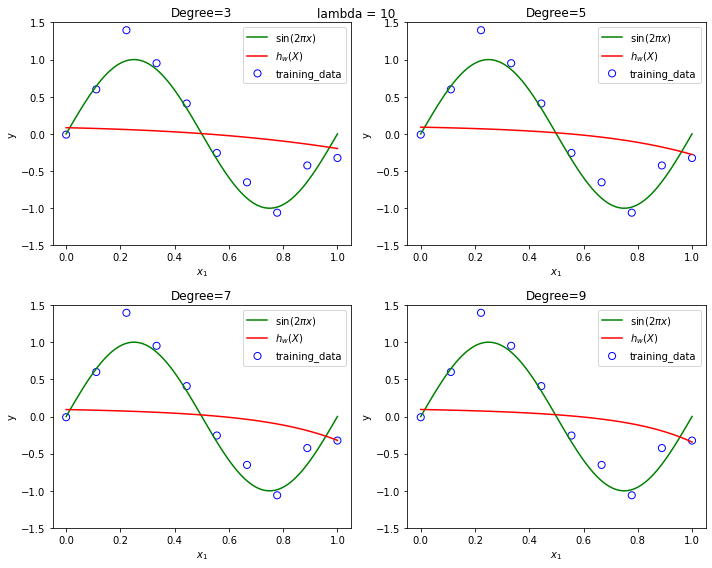

In [16]:
reg_rate = 10

fig = plt.figure(figsize=(10,8))

for i, degree in enumerate([3,5,7,9]):
    plt.subplot(2,2, i+1)

    X_transform = polynomial_transform(X, degree=degree)

    lin_reg = LinReg()
    lin_reg.fit(X_transform,y, reg_rate)

    visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

fig.tight_layout()
fig.suptitle('lambda = ' + str(reg_rate))
plt.show()

## Model Selection

- One model per $\lambda$. Which one to select?
- Process:
    - Fix the list of $\lambda$ s that you want to experiment with.
    - Divide the data into training, validation and test.
    - For each $\lambda$:
        - Training Ridge Regression model with $\lambda$ for training data.
        - Calculate training and validation errors on the trained model.
- Select the model with least training and validation loss.

### Model Selection Helper Functions

- Select the model with the lowst training and validation loss amongst all the models.

In [25]:
# This is to observe the variation of weights w.r.t. the variation of regularization rate
def plot_reg_w(w_df):
    '''
    This is to observe the variation of weights w.r.t. the variation 
    of regularization rate.
    
    w_df: The Pandas DataFrame containing the weights w.r.t. different regularization rate
    '''
    ax = plt.gca()
    ax.plot(w_df.T)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.xlabel('$\lambda$')
    plt.ylabel('w')
    plt.title('Weights as a function of $\lambda$ for degree = ' + str(degree))
    plt.axis('tight')
    plt.show()


def plot_learning_curve(err_df):
    '''
    This is to observe the variation of Training and Validation 
    RMSE w.r.t. the variation of regularization rate.
    
    err_df: The Pandas DataFrame containing the Training and Validation RMSE losses w.r.t. different regularization rate
    '''
    ax = plt.gca()
    ax.plot(err_df)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.xlabel('$\lambda$')
    plt.ylabel('RMSE')
    plt.title('Training and Validation losses as a function of $\lambda$ for degree = ' + str(degree))
    plt.axis('tight')
    plt.legend(['training', 'validation'])
    plt.show()

### Model Selection

In [47]:
import pandas as pd

# Regularization list, from these are the values of regularization that we will be checking.
reg_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]

# We will test higher degrees, because this is where regularization is more useful, because overfitting is noticeable here.
degree = 9

training_errors = {}
validation_errors = {}
w_dict = {}

# Create the validation set.
X_val = np.linspace(0,1,100)
y_val_without_noise = nonlin_sin(X_val)
y_val = y_val_without_noise + np.random.normal(scale=0.25, size=len(X_val))

X_transform = polynomial_transform(X,degree)
X_val_transform = polynomial_transform(X_val, degree)

# loop through for each reg_rate in reg_list
for reg_rate in reg_list:
    lin_reg = LinReg()
    lin_reg.fit(X_transform,y, reg_rate=reg_rate)

    w_dict[reg_rate] = lin_reg.w
    training_errors[reg_rate] = lin_reg.rmse(X_transform,y, reg_rate)
    validation_errors[reg_rate] = lin_reg.rmse(X_val_transform,y_val, reg_rate)

err_df = pd.DataFrame([training_errors,validation_errors]).T
w_df = pd.DataFrame(w_dict)

### Learning Curves

Let's plot learning curves with $\lambda$ on x-axis and $RMSE$ on the y-axis.

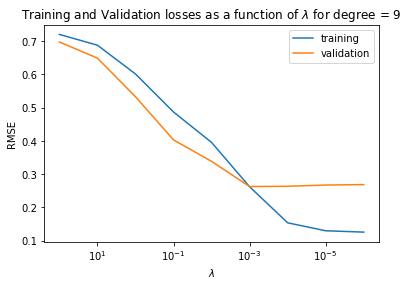

In [26]:
plot_learning_curve(err_df)

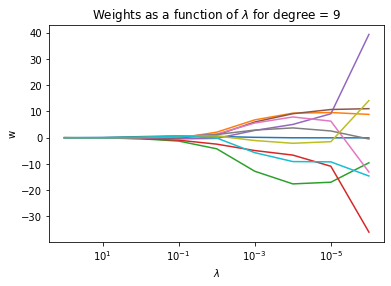

In [27]:
plot_reg_w(w_df)

**Observation:**

We notice that, here $10^{-3}$ is the sweer spot for regularization rate, because the training and validation error is close by and considerably low and the magnitude of the coefficients of the weight vector is also considerably low that than others.

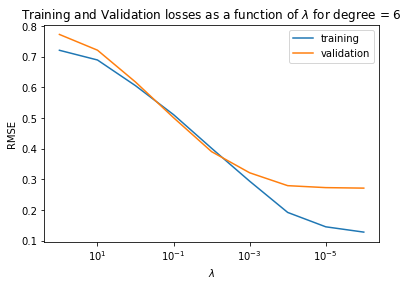

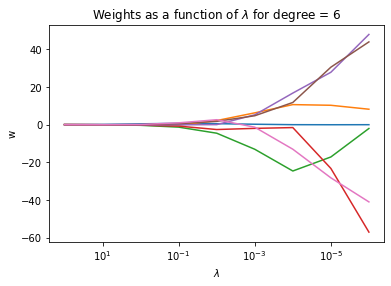

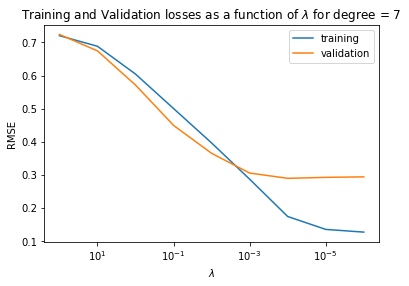

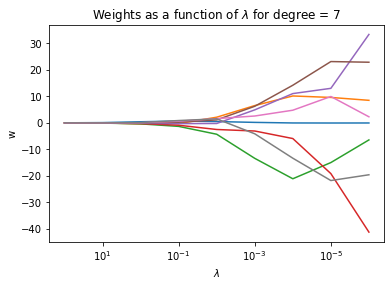

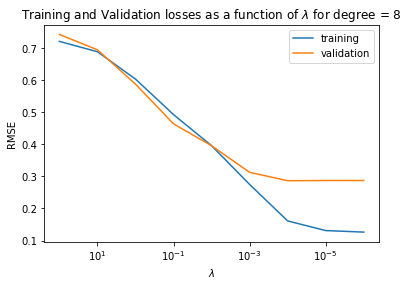

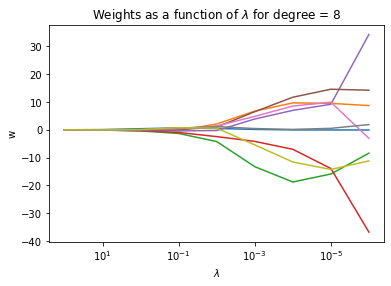

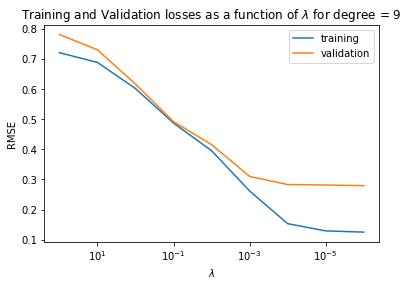

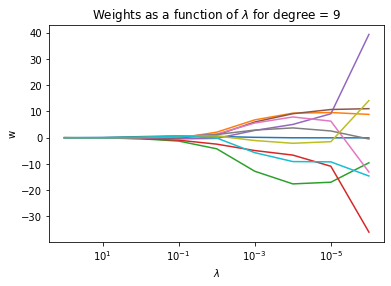

In [30]:
for deg in range(6,10):

    '''
    Complete Code to fit the model for reg_rates in reg_list
    '''
    import pandas as pd

    # Regularization list, from these are the values of regularization that we will be checking.
    reg_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]

    # We will test higher degrees, because this is where regularization is more useful, because overfitting is noticeable here.
    degree = deg

    training_errors = {}
    validation_errors = {}
    w_dict = {}

    # Create the validation set.
    X_val = np.linspace(0,1,100)
    y_val_without_noise = nonlin_sin(X_val)
    y_val = y_val_without_noise + np.random.normal(scale=0.25, size=len(X_val))

    X_transform = polynomial_transform(X,degree)
    X_val_transform = polynomial_transform(X_val, degree)

    # loop through for each reg_rate in reg_list
    for reg_rate in reg_list:
        lin_reg = LinReg()
        lin_reg.fit(X_transform,y, reg_rate=reg_rate)

        w_dict[reg_rate] = lin_reg.w
        training_errors[reg_rate] = lin_reg.rmse(X_transform,y, reg_rate)
        validation_errors[reg_rate] = lin_reg.rmse(X_val_transform,y_val, reg_rate)

    err_df = pd.DataFrame([training_errors,validation_errors]).T
    w_df = pd.DataFrame(w_dict)

    '''
    To plot the learning curves and weight magnitudes
    '''
    plot_learning_curve(err_df)
    plot_reg_w(w_df)

# Lasso Regression

Lasso uses $L_1$ norm of weight vector instead of $L_2$ as used in Ridge.

Lasso does not have closed form solution and it's loss function is not differentiable at all points. We need to use a specialized algorithm to learn the Lasso parameters. We will use the `sklearn.linear_model.Lasso` implentation.

In [31]:
from sklearn.linear_model import Lasso

# Lasso
reg_rate = 0.01
lasso_reg = Lasso(alpha=reg_rate)
lasso_reg.fit(X_transform, y)

# Linear Regression without Ridge Regularization
lin_reg = LinReg()
_ = lin_reg.fit(X_transform, y, 0)

Let's compare the weight vectors of linear, ridge and lasso regression for a fixed regularization rate of $\lambda = 0.01$.

In [32]:
# reg_rate = 0.01 for both Lasso and Ridge

pd.DataFrame({'LinReg': lin_reg.w, 'Ridge': w_df[0.01], 'Lasso':lasso_reg.coef_})

,LinReg,Ridge,Lasso
0,-0.009725,0.485001,0.000000
1,-74.469897,2.113715,-0.000000
2,1737.876246,-4.234139,-2.331668
3,-14576.769190,-2.458217,-0.000000
4,64455.271665,-0.263067,-0.000000
5,-168743.237335,1.008380,0.000000
6,270048.790251,1.411641,0.000000
7,-259177.046531,1.214711,0.000000
8,136878.047683,0.647992,0.000000
9,-30548.776974,-0.126682,1.249366


**Observations :**

1. Lasso obtains a sparse feature matrix vector. Many $0$ coefficients or weights.
2. Ridge regression assigns small weights to each feature.

A couple of points about Lasso and Ridge:
- Lasso is used for feature selection.
- While modeling relationship between features and labels:
    - When all features are useful for making prediction about the output, we use ridge regression. It produces a weight vector with small non-zero values to all features.
    - When a few features are useful for making predictions, we use lasso. It produces a weight vector that assigns $0$ weights to unimportant features.


Let's visualize the models learnt by the three models.

Text(0.5, 1.0, 'Lasso Regression (degree = 9), $\\lambda = 0.01$')

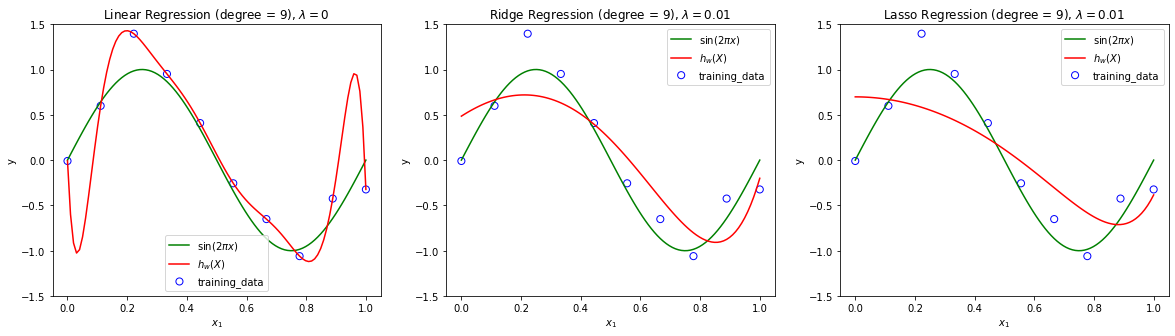

In [35]:
from sklearn.linear_model import Lasso

# for higher degree models
degree = 9

f = plt.figure(figsize=(20,5))

# Polynomial Regression
ax1 = plt.subplot(1,3,1)
lin_reg.fit(X_transform,y, reg_rate=0)
visualize_model_fit(X,y, lin_reg, degree)
plt.title('Linear Regression (degree = ' + str(degree) + '), $\lambda = 0$')

# Ridge Regression
ax2 = plt.subplot(1,3,2)
lin_reg.fit(X_transform,y, reg_rate=0.01)
visualize_model_fit(X,y, lin_reg, degree)
plt.title('Ridge Regression (degree = ' + str(degree) + '), $\lambda = 0.01$')

# Lasso Regression
ax3 = plt.subplot(1,3,3)
lasso_reg = Lasso(alpha = 0.01)
lasso_reg.fit(X_transform,y)
visualize_model_fit(X,y, lasso_reg, degree)
plt.title('Lasso Regression (degree = ' + str(degree) + '), $\lambda = 0.01$')

Let's look at Lasso Regression with different regularization rates:

<ipython-input-41-8e6612c0f595>:15: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_reg.fit(X_transform,y)
/Volumes/SKK-T7/Apps/anaconda3/envs/skk-mlp-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Volumes/SKK-T7/Apps/anaconda3/envs/skk-mlp-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09542005019796725, tolerance: 0.0005235058899843125
  model = cd_fast.enet_coordinate_descent(
/Volumes/SKK-T7/Apps/anaconda3/envs/skk-mlp-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the

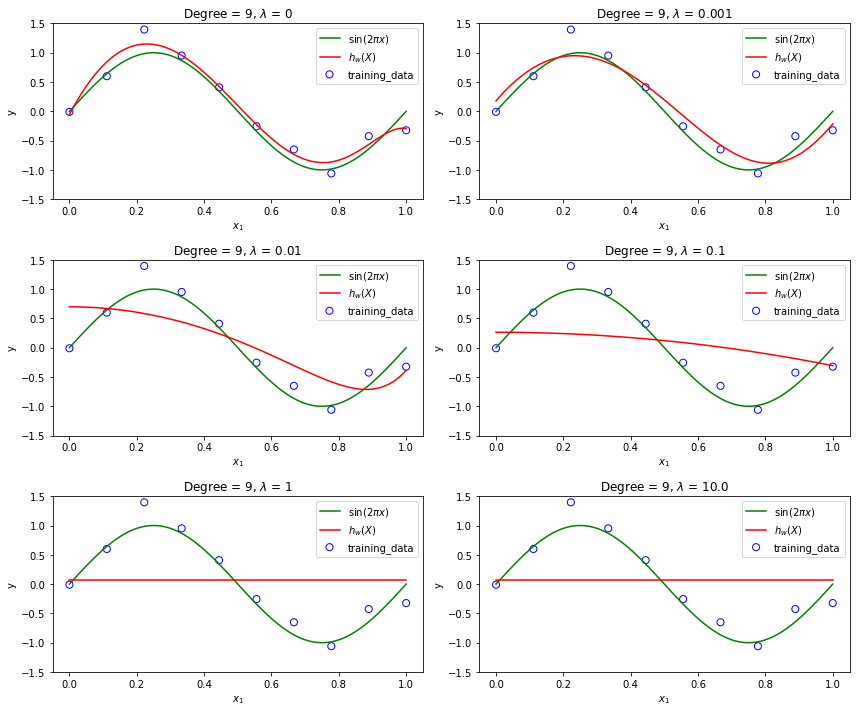

In [41]:
from sklearn.linear_model import Lasso

# We will look at regularization for a fixed degree
degree = 9

# We will look at the fittings for Lasso Regression for these regularization rates
reg_list = [0, 1e-3, 1e-2, 1e-1, 1, 1e+1]

f = plt.figure(figsize=(12,10))

for i, reg_rate in enumerate(reg_list):
    plt.subplot(3,2,i+1)
    lasso_reg = Lasso(alpha=reg_rate)
    X_transform = polynomial_transform(X, degree=degree)
    lasso_reg.fit(X_transform,y)
    visualize_model_fit(X,y, lasso_reg, degree)
    plt.title('Degree = ' + str(degree) + ', ' + '$\lambda$ = ' + str(reg_rate))

f.tight_layout()
plt.show()

## Model Selection

In [46]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Regularization list, from these are the values of regularization that we will be checking.
reg_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]

# We will test higher degrees, because this is where regularization is more useful, because overfitting is noticeable here.
degree = 9

training_errors_lasso = {}
validation_errors_lasso = {}
w_dict_lasso = {}

# Create the validation set.
X_val = np.linspace(0,1,100)
y_val_without_noise = nonlin_sin(X_val)
y_val = y_val_without_noise + np.random.normal(scale=0.25, size=len(X_val))

X_transform = polynomial_transform(X,degree)
X_val_transform = polynomial_transform(X_val, degree)

# loop through for each reg_rate in reg_list
for reg_rate in reg_list:
    lasso_reg = Lasso(alpha=reg_rate)
    lasso_reg.fit(X_transform,y)

    w_dict_lasso[reg_rate] = lasso_reg.coef_
    training_errors_lasso[reg_rate] = mean_squared_error(y, lasso_reg.predict(X_transform), squared=False)
    validation_errors_lasso[reg_rate] = mean_squared_error(y_val, lasso_reg.predict(X_val_transform), squared=False)

err_df_lasso = pd.DataFrame([training_errors_lasso,validation_errors_lasso]).T
w_df_lasso = pd.DataFrame(w_dict_lasso)

/Volumes/SKK-T7/Apps/anaconda3/envs/skk-mlp-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09517515435144036, tolerance: 0.0005235058899843125
  model = cd_fast.enet_coordinate_descent(
/Volumes/SKK-T7/Apps/anaconda3/envs/skk-mlp-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09296469687581348, tolerance: 0.0005235058899843125
  model = cd_fast.enet_coordinate_descent(
/Volumes/SKK-T7/Apps/anaconda3/envs/skk-mlp-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07147108699629728, tolerance: 0.0005235058899843125
  model = cd_fast.enet_coordinate_d

### Learning Curves

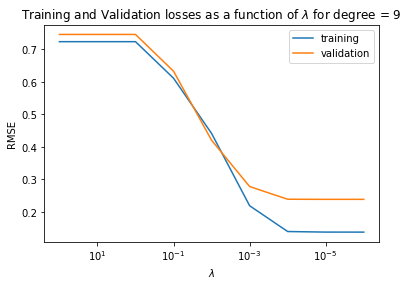

In [45]:
plot_learning_curve(err_df_lasso)

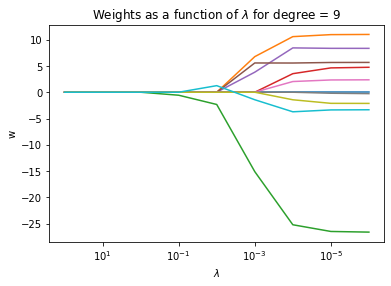

In [48]:
plot_reg_w(w_df_lasso)

**Observation:**

We notice that, here $10^{-2}$ or $10^{-3}$ is the sweet spot for regularization rate, because the training and validation error is close by and considerably low and the magnitude of the coefficients of the weight vector is also considerably low that than others.